# Faster RCNN for HE

Schema of Faster RCNN:
![Faster RCNN](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rQ99lLIs7xTAjTaKHHNatA.png)

## Feature extraction

Create dummy image, target boxes and object labels

In [197]:
import torch
image = torch.zeros((1, 3, 800, 800)).float()
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background
sub_sample = 16

Plot target boxes inside image

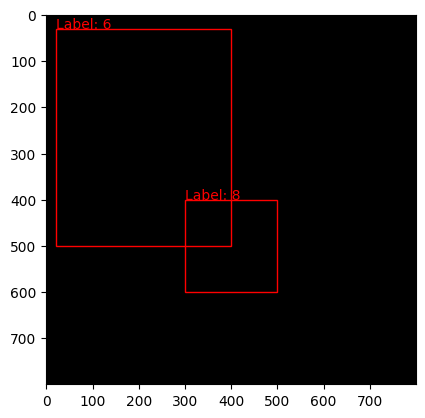

In [198]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Plot the image
plt.imshow(image[0].permute(1, 2, 0))

# Plot the bounding boxes
for i in range(len(bbox)):
    x_min, y_min, x_max, y_max = bbox[i]
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(x_min, y_min, f'Label: {labels[i]}', color='r')

# Show the plot
plt.show()


In [199]:
import torchvision
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


Import VGG16 model to extract feature from image

In [200]:
model = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
fe = list(model.features)
print(fe)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Pass the image through the layers and check where you are getting this size.

In [201]:
req_features = []
k = dummy_img.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) 
print(out_channels) 

30
512


Convert this list into a Sequential module.

In [202]:
import torch.nn as nn
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

Lets compute the features

In [203]:
out_map = faster_rcnn_fe_extractor(image)
print(out_map.size())

torch.Size([1, 512, 50, 50])


## Anchor Boxes

We will use anchor_scales of 8, 16, 32, ratio of 0.5, 1, 2 and sub sampling of 16 (Since we have pooled our image from 800 px to 50px). 
>   Now every pixel in the output feature map maps to corresponding 16 * 16 pixels in the image.



### Generate Anchor at a single feature map location

At each pixel location on the feature map, We need to generate 9 anchor boxes (number of anchor_scales and number of ratios) and each anchor box will have ‘y1’, ‘x1’, ‘y2’, ‘x2’. So at each location anchor will have a shape of (9, 4).

In [204]:
import numpy as np
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]
anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [205]:
ctr_y = sub_sample / 2.
ctr_x = sub_sample / 2.
print(ctr_y, ctr_x)

8.0 8.0


Lets fill these values with corresponding y1, x1, y2, x2 at each anchor_scale and ratios. 

In [206]:
for i in range(len(ratios)):
  for j in range(len(anchor_scales)):
    h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
    w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
    index = i * len(anchor_scales) + j
    anchor_base[index, 0] = ctr_y - h / 2.
    anchor_base[index, 1] = ctr_x - w / 2.
    anchor_base[index, 2] = ctr_y + h / 2.
    anchor_base[index, 3] = ctr_x + w / 2.
print(anchor_base)

[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


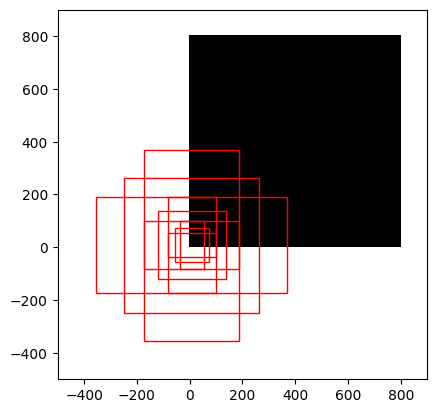

In [207]:
import matplotlib.pyplot as plt


# Dimensions of the white rectangle
rect_width = 800
rect_height = 800

# Plotting
fig, ax = plt.subplots()
image = np.zeros((800, 800, 3), dtype=np.uint8)
# Plotting the white rectangle
plt.imshow(image)

# Plotting the anchor boxes
for box in anchor_base:
    y_min, x_min, y_max, x_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Setting limits
ax.set_xlim(-500, rect_width + 100)
ax.set_ylim(-500, rect_height + 100)

# Aspect ratio to maintain square aspect
ax.set_aspect('equal', adjustable='box')

# Show plot
plt.show()


These are the anchor locations at the first feature map pixel

### Generate Anchor at all the feature map location

we need to first generate the centres for each and every feature map pixel.



In [208]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(ctr_x.shape, ctr_y.shape)

(50,) (50,)


In [209]:
ctr = np.zeros(shape=(len(ctr_x) * len(ctr_y),2))
ctr.shape

(2500, 2)

In [210]:
index = 0
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1

Looping through the ctr_x and ctr_y will give us the centers at each and every location.

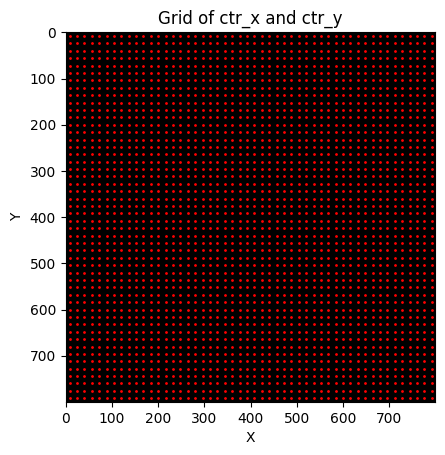

In [211]:
image = np.zeros((800, 800, 3), dtype=np.uint8)


plt.imshow(image)
# Plot the points of the grid above the image
for idx in range(ctr.shape[0]):
        plt.plot(ctr[idx][0], ctr[idx][1], color='red', marker='o', markersize=1)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grid of ctr_x and ctr_y')

# Show the plot
plt.show()

The output will be the (x, y) value at each location as shown in the image above. Together we have 2500 anchor centers. Now at each center we need to generate the anchor boxes.

In [212]:
# 9 anchors at each sliding window position, for each scale, for each ratio
# 4 co-ordinates for each anchor (y1, x1, y2, x2)
anchors = np.zeros(shape=((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
      h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
      w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
      anchors[index, 0] = ctr_y - h / 2.
      anchors[index, 1] = ctr_x - w / 2.
      anchors[index, 2] = ctr_y + h / 2.
      anchors[index, 3] = ctr_x + w / 2.
      index += 1
print(anchors.shape)

(22500, 4)


### Assign the labels and location of objects.

Isolate only valid bbox (that are inside image):
1.  Find the indexes of valid anchor boxes and create an array with these indexes. create an label array with shape index array filled with -1.
2.  Check weather one of the conditition a, b, c is statisfying or not and fill the label accordingly. In case of positive anchor box (label is 1), note which ground truth object has resulted in this.
    * a. The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box.
    * b. An anchor that has an IoU overlap higher than 0.7 with ground-truth box.
    * c. We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
3.  Calculate the locations (loc) of ground truth associated with the anchor box wrt to the anchor box.
4.  Reorganize all anchor boxes by filling with -1 for all unvalid anchor boxes and values we have calculated for all valid anchor boxes.
5.  Outputs should be labels with (N, 1) array and locs with (N, 4) array.
6.  Find the index of all valid anchor boxes

In [213]:
from collections import Counter

bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # [y1, x1, y2, x2] format
labels = np.asarray([6, 8], dtype=np.int8) # 0 represents background

Find the indexes of valid anchor boxes, the one that are inside images and create an array with these indexes.

In [214]:
index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 800) &
        (anchors[:, 3] <= 800)
    )[0]
print(index_inside.shape)

(8940,)


create an label array with shape index array filled with -1.

In [215]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)
print(Counter(label))

(8940,)
Counter({-1: 8940})


Obtain only valid anchor boxes from valid indexes 

In [216]:
valid_anchor_boxes = anchors[index_inside]
print(valid_anchor_boxes.shape)
#Out = (8940, 4)

(8940, 4)


For each valid anchor box calculate the iou with each ground truth object. Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8490, 2) as the output.

In [217]:
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
print(bbox)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area/(anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

[[ 20.  30. 400. 500.]
 [300. 400. 500. 600.]]
(8940, 2)


we need to find two things here:
* the highest iou for each gt_box and its corresponding anchor box (how well the anchor boxes align with the ground truth objects they are supposed to detect.)
* the highest iou for each anchor box and its corresponding ground truth box (how well the ground truth objects align with the anchor boxes, identifying which ground truth object each anchor box best matches with.)

In [218]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[2262 5620]
[0.68130493 0.61035156]


In [219]:
# argmax_ious — Tells which ground truth object has max iou with each anchor.
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
# max_ious — Tells the max_iou with ground truth object with each anchor.
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0.06811669 0.07083762 0.07083762 ... 0.         0.         0.        ]


Check weather one of the conditition a, b, c is statisfying or not and fill the label accordingly. In case of positive anchor box (label is 1), note which ground truth object has resulted in this.
* a. The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box.
>   Consider a scenario where multiple ground truth objects are present in an image, and an anchor box overlaps with more than one of these objects. In such cases, point a helps identify which ground truth object resulted in the anchor box being labeled as positive.
* b. An anchor that has an IoU overlap higher than 0.7 with ground-truth box.
* c. We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes

In [220]:
# gt_argmax_ious — Tells the anchors with the highest Intersection-over-Union (IoU) overlap with a ground-truth box.
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[2262 2508 5620 5628 5636 5644 5866 5874 5882 5890 6112 6120 6128 6136
 6358 6366 6374 6382]


In [221]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3

In [222]:
# Assign negitive label (0) to all the anchor boxes which have max_iou less than negitive threshold
label[max_ious < neg_iou_threshold] = 0

In [223]:
# Assign positive label (1) to all the anchor boxes which have highest IoU overlap with a ground-truth box
label[gt_argmax_ious] = 1

In [224]:
# Assign positive label (1) to all the anchor boxes which have max_iou greater than positive threshold
label[max_ious >= pos_iou_threshold] = 1

In [225]:
print(Counter(label))

Counter({0: 7690, -1: 1232, 1: 18})


## Train RPN

From paper: 
> Each mini-batch arises from a single image that contains many positive and negitive example anchors, but this will bias towards negitive samples as they are dominate. Instead, we randomly sample 256 anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1. If there are fewer than 128 positive samples in an image, we pad the mini-batch with negitive ones.

In [226]:
pos_ratio = 0.5
n_sample = 256

In [227]:
n_pos = pos_ratio * n_sample

Now we need to randomly sample n_pos samples from the positive labels and ignore (-1) the remaining ones. In some cases we get less than n_pos samples, in that we will randomly sample (n_sample — n_pos) negitive samples (0) and assign ignore label to the remaining anchor boxes.

Positive samples:

In [228]:
pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

Negitive samples:

In [229]:
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [230]:
print(Counter(label))

Counter({0: 4608, -1: 4314, 1: 18})


## Assign location to anchor boxes

Rather than directly predicting the absolute coordinates of the bounding box vertices, Faster R-CNN predicts adjustments or offsets to the coordinates of the anchor box to better align with the ground truth object.

For each anchor box, find the groundtruth object which has max_iou

In [231]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

[[ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 ...
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]
 [ 20.  30. 400. 500.]]


convert the y1, x1, y2, x2 format of valid anchor boxes and associated ground truth boxes with max iou to ctr_y, ctr_x , h, w format, to obtain the right shift

In [232]:
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

Find the location shift

In [233]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
# log for stabilization purposes
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[ 0.5855728   2.30914558  0.7415674   1.64727602]
 [ 0.49718446  2.30914558  0.7415674   1.64727602]
 [ 0.40879611  2.30914558  0.7415674   1.64727602]
 ...
 [-2.50801936 -5.29225232  0.7415674   1.64727602]
 [-2.59640771 -5.29225232  0.7415674   1.64727602]
 [-2.68479606 -5.29225232  0.7415674   1.64727602]]


Lets map them to the original anchors using the inside_index variable. Fill the unvalid anchor boxes labels with -1 (ignore) and locations with 0.

In [234]:
anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

(22500,)


In [235]:
anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500, 4)


### Build RPN

Build regression layer and classification layer

In [236]:
import torch.nn as nn
mid_channels = 512
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9 # Number of anchors at each location
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) ## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.

According to paper set 0 mean and 0.01 of bias

In [237]:
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now the outputs we got in the feature extraction state should be sent to this network to predict locations of objects with repect to the anchor and the objectness score assoiciated with it.

In [238]:
x = conv1(out_map) # out_map is obtained in section 1
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


Lets reformat these a bit and make it align with our anchor targets we designed previously. We will also find the objectness scores for each anchor box, as this is used to for proposal layer which we will discuss in the next section



In [239]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

torch.Size([1, 22500, 4])


In [240]:
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

torch.Size([1, 50, 50, 18])


In [241]:
objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

torch.Size([1, 22500])


In [242]:
pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 2])


## Generating proposals to feed Fast R-CNN network using Non Max Suppression

Reduce number of proposal by deleting high overlapping ones

In [243]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

### Convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format

Convert anchors format from y1, x1, y2, x2 to ctr_x, ctr_y, h, w

In [244]:
anc_height = anchors[:, 2] - anchors[:, 0]
anc_width = anchors[:, 3] - anchors[:, 1]
anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

Convert predictions locs using above formulas. before that convert the pred_anchor_locs and objectness_score to numpy array

In [245]:
pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
objectness_score_numpy = objectness_score[0].data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2] format

In [246]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=float)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
roi

array([[ -39.8491374 ,  -77.72937648,   48.31005008,  105.31892093],
       [ -84.04224761, -173.55516337,   97.60687693,  185.14393529],
       [-180.78738589, -343.4923544 ,  174.52796685,  399.98614552],
       ...,
       [ 702.71322248,  744.92713645,  884.62947577,  837.85890627],
       [ 610.44259982,  703.97079661,  975.65077953,  883.03675226],
       [ 426.61698538,  610.71744717, 1147.52792897,  975.18325971]])

clip the predicted boxes to the image

In [247]:
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

print(roi)

[[  0.           0.          48.31005008 105.31892093]
 [  0.           0.          97.60687693 185.14393529]
 [  0.           0.         174.52796685 399.98614552]
 ...
 [702.71322248 744.92713645 800.         800.        ]
 [610.44259982 703.97079661 800.         800.        ]
 [426.61698538 610.71744717 800.         800.        ]]


Remove predicted boxes with either height or width < minimmum size (16).

In [248]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(score.shape)

(22500,)


### Apply NMS

- Take all the roi boxes [roi_array]
- Find the areas of all the boxes [roi_area]
- Take the indexes of order the probability score in descending order [order_array]
- keep = []
- while order_array.size > 0:
  - take the first element in order_array and append that to keep  
  - Find the area with all other boxes
  - Find the index of all the boxes which have high overlap with this box
  - Remove them from order array
  - Iterate this till we get the order_size to zero (while loop)
- Ouput the keep variable which tells what indexes to consider.

Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

In [192]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
area = (x2 - x1 + 1) * (y2 - y1 + 1)
order = score.argsort()[::-1]
keep = []
while order.size > 0:
    i = order[0]
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (area[i] + area[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals

## Proposal target

The Fast R-CNN network takes the region proposals (obtained from proposal layer in previous section), ground truth boxes and their respective labels as inputs. 
It will take the following parameters:

- n_sample: Number of samples to sample from roi, The default value is 128.
- pos_ratio: the number of positive examples out of the n_samples. The default values is 0.25.
- pos_iou_thesh: The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
- [neg_iou_threshold_lo, neg_iou_threshold_hi] : [0.0, 0.5], The overlap value bounding required to consider a region proposal as negitive [background object].


In [194]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

Find the iou of each ground truth object with the region proposals

In [196]:
roi[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [195]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(0, 2)
